In [1]:
import sys
from copy import deepcopy

import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns
plt = matplotlib.pyplot

%matplotlib inline

sns.set_style('whitegrid')

matplotlib.rcParams.update({'figure.figsize': (10, 6)})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})

%config InlineBackend.figure_format = 'retina'

In [2]:
# https://www.kaggle.com/shivam2503/diamonds/data
diamonds = pd.read_csv('data/diamonds.csv')

# Features
data = deepcopy(diamonds[['carat', 'x', 'y', 'z', 'depth', 'table', 'price',
                          'clarity', 'color']])
# Labels
target = deepcopy(diamonds['cut']).astype('category')

# Force all numerical data to zero mean one std
for col in ['carat','x','y','z','depth','table','price']:
    data[col] = (data[col] - data[col].mean()) / data[col].std()

# Define color and clarity as categorical types
for col in ['color', 'clarity']:
    data[col] = data[col].astype('category');

data.describe()

,carat,x,y,z,depth,table,price
count,5.394000e+04,5.394000e+04,5.394000e+04,5.394000e+04,5.394000e+04,5.394000e+04,5.394000e+04
mean,2.149807e-16,2.508108e-16,-2.107654e-17,-2.023348e-16,-4.002434e-15,1.175017e-16,-1.095980e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.261446e+00,-5.109073e+00,-5.020884e+00,-5.014510e+00,-1.308748e+01,-6.470013e+00,-9.040868e-01
25%,-8.395154e-01,-9.103164e-01,-8.882717e-01,-8.909378e-01,-5.231005e-01,-6.521325e-01,-7.476738e-01
50%,-2.066190e-01,-2.777527e-02,-2.147379e-02,-1.237607e-02,3.531645e-02,-2.046032e-01,-3.839636e-01
75%,5.106635e-01,7.210475e-01,7.052356e-01,7.103118e-01,5.239313e-01,6.904554e-01,3.487834e-01
max,8.885992e+00,4.465161e+00,4.654922e+01,4.004720e+01,1.204128e+01,1.680151e+01,3.732404e+00


In [3]:
from functools import reduce
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, Embedding, Flatten, Merge, concatenate
from keras.callbacks import Callback

class WideDeepNetwork():
    def __init__(
        self, epochs=5, batch_size=35, activation='relu', final_activation='sigmoid', optimizer='adagrad', 
        loss='mean_squared_error', metrics=['accuracy'], deep_input_size=5, 
        deep_layer_sizes=[50,10], numeric_features=None, categorical_features=None,
        cross_categories=None,
    ):
        self.epochs = epochs
        self.batch_size = batch_size
        
        self.activation = activation
        self.final_activation = final_activation
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics
        
        self.deep_input_size = deep_input_size
        self.deep_layer_sizes = deep_layer_sizes
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.cross_categories = cross_categories
        
        self._model = self._make_model()
        
    def _make_wide_network(self):
        # we need to create separate sequential models for each embedding
        input_layer = []
        outputs = []
        
        if not all(isinstance(element, list) for element in self.cross_categories):
            raise ValueError('cross_categories should be type [[]]')
        
        for category_group in self.cross_categories:
            # N([a,b,...]) = (a_classes * b_classes * ...)
            N = 1 + reduce(lambda a,b:a*b, map(lambda x:len(self.categorical_features[x]), category_group))

            # create embedding branch from the number of crossed classes
            inp = Input(shape=(1,),dtype='int32', name = '_'.join(category_group))
            input_layer.append(inp)
            
            out = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inp)
            out = Flatten()(out)
            outputs.append(out)
        output_layer = concatenate(outputs) if len(outputs) > 1 else outputs[0]
        return input_layer, output_layer
    
    def _make_deep_network(self):
        if not all(isinstance(element, list) for _, element in self.categorical_features.items()):
            raise ValueError(
                'WideDeepNetwork.categorical_features must be a dictionary where every key is a category '
                'name (string) and every value is a list of that category\'s classes (list(string)).'
            )
        input_layer = []
        outputs = []
        
        for category_name, category_classes in self.categorical_features.items():
            # N is the largest integer which will encode the category's classes.
            N = len(category_classes) # TEST

            inp = Input(shape=(1,),dtype='int32', name=category_name)
            input_layer.append(inp)

            out = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inp)
            out = Flatten()(out)
            outputs.append(out)

        # also get a dense branch of the numeric features
        if len(self.numeric_features) < 1:
            raise ValueError('Numeric Features must not be empty')
        
        input_layer.append(Input(shape=(len(self.numeric_features),),sparse=False, name='numeric_data'))

        # Gets a dense encoding of all the numerical data
        out = Dense(units=self.deep_input_size, activation=self.activation)(input_layer[-1])
        outputs.append(out)

        output_layer = concatenate(outputs)
        
        # Define the deep layer 
        for units in self.deep_layer_sizes:
            output_layer = Dense(units=units,activation=self.activation)(output_layer)
            
        return input_layer, output_layer
        
    def _make_model(self):
        # Get all input layers and the network branches
        wide_input, wide_branch = self._make_wide_network()
        deep_input, deep_branch = self._make_deep_network()
        # combine inputs
        all_inputs = wide_input + deep_input
        # Define the final output branch to dense 5 nuron output
        final_branch = concatenate([wide_branch, deep_branch])
        final_branch = Dense(units=5,activation=self.final_activation)(final_branch)
        # Define model with input and outputs
        model = Model(inputs=all_inputs, outputs=final_branch)
        # Compile to model to allow fiting
        model.compile(optimizer=self.optimizer,
                           loss=self.loss,
                           metrics=self.metrics)
        return model
    
    def _prepare_data(self, X_raw):
        # Model requires X in format of [crossed_categorical(ints), Cat_1, Cat_2, Cat_n, [numerical_data]]
        # whereas an unorganized pandas dataframe is provided (X_raw)
        X = []
        # crossed categorical features
        for category_group in self.cross_categories:
            crossed = X_raw[category_group].apply(lambda x: '_'.join(x), axis=1).astype('category')
            X.append(crossed.cat.codes)
        # normal categorical features
        for category in self.categorical_features.keys():
            X.append(X_raw[category].cat.codes)
        # numeric features
        X.append(np.asarray(X_raw[self.numeric_features]))
        return X
    
    def fit(self, X_raw, y_raw, print_progress=False):
        # Using keras Callbacks to hook into end of epoch
        # for per-epoch evaluation statistics collection
        # [CITE] https://github.com/fchollet/keras/issues/2548#issuecomment-215664770
        self.epoch_log_ = []
        net = self
        class AnalyticsCallback(Callback):
            def on_epoch_end(self, epoch, logs={}):
                net.epoch_log_.append(logs)
        
        X = self._prepare_data(X_raw)
        y = np.asarray(pd.get_dummies(y_raw))
        self._model.fit(
            X, y, 
            epochs=self.epochs,
            batch_size=self.batch_size, 
            verbose=print_progress,
            callbacks=[AnalyticsCallback()]
        )
    
    def predict(self, X_raw):
        X = self._prepare_data(X_raw)
        return self._model.predict(X)
    
    @staticmethod
    def one_hot_output(y_hat_raw):
        # predict() outputs floats. We want one-hot in most cases
        y_hat = np.zeros(y_hat.shape)
        y_hat[np.arange(y_hat_raw.shape[0]), y_hat_raw.argmax(1)] = 1
        return y_hat

Using TensorFlow backend.


In [ ]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from multiprocessing import Pool

# Define features
numeric_features = ['carat', 'x', 'y', 'z', 'depth', 'table', 'price']
cross_categories = [['clarity','color']]
categorical_features = {c: data[c].unique().tolist() for c in ['clarity', 'color']}

def cross_validation_run(indices):
    train_index, test_index = indices
    # training
    wdNet = WideDeepNetwork(
        epochs               = 1,
        batch_size           = 32,
        optimizer            = 'Nadam',
        loss                 = 'categorical_crossentropy',
        metrics              = ['categorical_accuracy'],
        deep_input_size      = 25,
        deep_layer_sizes     = [35,80,60,25],
        numeric_features     = numeric_features, 
        categorical_features = categorical_features, 
        cross_categories     = cross_categories
    )
    wdNet.fit(data.iloc[train_index], target.iloc[train_index], print_progress=False)
    
    # testing
    y_hat_raw = wdNet.predict(target.iloc[test_index])
    y_hat = WideDeepNetwork.one_hot_output(y_hat_raw)
    print('done')
    return roc_auc_score(target.iloc[test_index], y_hat)

n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, random_state=None, shuffle=False)

cv_indices = cv.split(data, target)

with Pool(n_splits) as p:
    print(p.map(cross_validation_run, cv_indices))
    

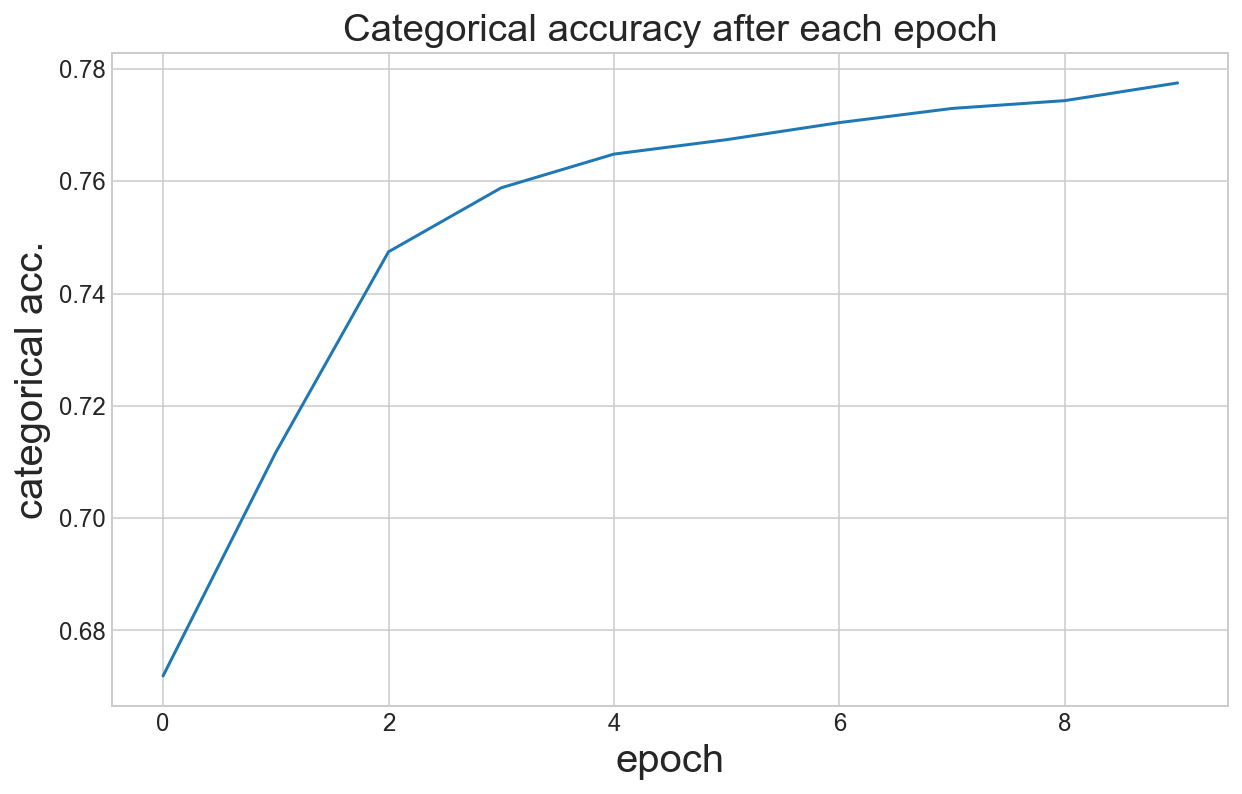

In [5]:
acc = [epoch['categorical_accuracy'] for epoch in wdNet.epoch_log_]

plt.plot(np.arange(len(acc)), acc)
plt.xlabel('epoch')
plt.ylabel('categorical acc.')
plt.title('Categorical accuracy after each epoch');

In [6]:
from sklearn.metrics import confusion_matrix

y_hat_raw = wdNet.predict(y_test)
y_hat = WideDeepNetwork.one_hot_output(y_hat_raw)

cnf = confusion_matrix(y_test, y_hat)
print(cnf)
cnf_norm = cnf.astype('float') / cnf.sum(axis=1)[:, np.newaxis]

sns.heatmap(cnf_norm)
plt.title('Normalized confusion matrix')

KeyError: "None of [['clarity', 'color']] are in the [index]"

In [ ]:
from sklearn.metrics import roc_auc_score


# gets the column of the maximum for each row
# then converts it to binary (manual one-hot encoding)
y_hat_one_hot = np.zeros(y_hat.shape)
y_hat_one_hot[np.arange(y_hat.shape[0]), y_hat.argmax(1)] = 1

# ROC Area under Curve score
roc_auc_score(
    np.asarray(target_test_one_hot),
    y_hat_one_hot
)


In [ ]:
data['clarity'].value_counts().keys().tolist()